<a href="https://colab.research.google.com/github/VihaanMotwani/WellNest-AI/blob/main/employee_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/data-mining/sentiment-analysis/sentiment-analysis.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/data-mining/sentiment-analysis/sentiment-analysis.ipynb)

# Sentiment Analysis with Pinecone

Sentiment analysis, often known as opinion mining, is a technique used in natural language processing (NLP) to determine the emotional undertone of a text. This is a common method used by organizations to identify and group opinions about their product, service, and ideas. In this notebook, we will apply this technique to the hotel industry and understand customer perception and potential areas that need improvement. To do this, we will:

1.	Generate Sentiment labels and scores based on customer reviews.
2.	Store them in a Pinecone index as metadata (alongside respective text vectors).
3.	Query Pinecone index on selected areas and understand customer opinions.

Let's get started.


# Install Dependencies

In [15]:
!pip install sentence_transformers pinecone-client datasets seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


# Load and Prepare Dataset

We use a dataset containing ~90k hotel reviews provided by customers. This dataset can be loaded from the HuggingFace dataset hub as follows:

In [5]:
#input_database = input("Enter the file name of your csv database: ")
# df = pd.read_csv(input_database)
df = pd.read_csv("data")
'''from datasets import load_dataset

# load the dataset and convert to pandas dataframe
df = load_dataset(
    "ashraq/hotel-reviews",
    split="train"
).to_pandas()'''

'from datasets import load_dataset\n\n# load the dataset and convert to pandas dataframe\ndf = load_dataset(\n    "ashraq/hotel-reviews",\n    split="train"\n).to_pandas()'

In [14]:
# keep only the first 800 characters from the reviews
# glimpse the dataset
df.head()

,dept,feed
0,IT,The work environment at our company is charact...
1,Operation/Manufacturing/Production,Our work environment is a melting pot of ideas...
2,Administration,"In the workplace, there's a palpable sense of ..."
3,IT,"The work environment here is dynamic, reflecti..."
4,Finance & Accounting,"Our office culture thrives on diversity, ensur..."


# Initialize Sentiment Analysis Model

We will use a RoBERTa model fine-tuned for sentiment analysis to analyze the hotel reviews. The model can be loaded from the HuggingFace model hub as follows:

In [6]:
import torch

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

model_id = "cardiffnlp/twitter-roberta-base-sentiment"

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

The sentiment analysis model returns `LABEL_0` for negative, `LABEL_1` for neutral and `LABEL_2` for positive labels. We can add them to a dictionary to easily access them when showing the results.

In [10]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [11]:
# view review number 241
test_review = df["feed"][56]
test_review

'When projects consume nights and weekends, employee health suffers chronically. Still, vision propels us onward as a tight-knit community. With stronger work-life policies, our vitality and camaraderie might thrive more consistently.\xa0'

In [12]:
# get the sentiment label and score for review number 241
nlp(test_review)

[{'label': 'LABEL_2', 'score': 0.724312424659729}]

Our pipeline is working as expected and accurately predicts the correct label for the review.

# Initialize Retriever

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:

In [16]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

# Initialize Pinecone Index

Now we need to initialize our Pinecone index. The Pinecone index stores vector representations of our passages which we can retrieve using another vector (the query vector). We first need to initialize our connection to Pinecone. For this, we need a free [API key](https://app.pinecone.io/), we initialize the connection like so:

In [17]:
from pinecone import Pinecone, ServerlessSpec
# connect to pinecone environment
pc = Pinecone(api_key="adc052fa-fe00-40bd-ae1a-011f955b497d")
index = pc.Index("sentiment-mining")

Now we can create our vector index. We will name it `sentiment-mining` (feel free to choose any name you prefer). We specify the metric type as `cosine` and dimension as `384` as these are the vector space and dimensionality of the vectors generated by the retriever model.

In [18]:
'''index_name = "sentiment-mining"

# check if the sentiment-mining index exists
if index_name not in pinecone.list_indexes().names():
    # create the index if it does not exist
    pinecone.create_index(
        index_name,
        dimension=384,
        metric="cosine"
    )

# connect to sentiment-mining index we created
index = pinecone.Index(index_name)'''

'index_name = "sentiment-mining"\n\n# check if the sentiment-mining index exists\nif index_name not in pinecone.list_indexes().names():\n    # create the index if it does not exist\n    pinecone.create_index(\n        index_name,\n        dimension=384,\n        metric="cosine"\n    )\n\n# connect to sentiment-mining index we created\nindex = pinecone.Index(index_name)'

# Generate Embeddings and Upsert

We generate embeddings for all the reviews in the dataset. Alongside the embeddings, we also include the sentiment label and score in the Pinecone index as metadata. Later we will use this data to understand customer opinions.

Let's first write a helper function to generate sentiment labels and scores for a batch of reviews.

In [19]:
def get_sentiment(feed):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(feed)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [20]:
# get sentiment labels for few reviews
get_sentiment(df["feed"][:3].tolist())

(['positive', 'positive', 'neutral'],
 [0.7111546397209167, 0.893977165222168, 0.49795377254486084])

We need to convert the review dates to timestamps to filter query results for a given period. This is helpful if you want to understand customer sentiment over a specific period. Let's write another helper function to convert dates to timestamps.

In [21]:
import dateutil.parser

# convert date to timestamp
def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

In [22]:
get_timestamp([df["review_date"][0]])[0]

KeyError: 'review_date'

Now we create the embeddings. We do this in batches of `64` to avoid overwhelming machine resources or API request limits.

In [23]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(df))
    # extract batch
    batch = df.loc[i:i_end]
    # generate embeddings for batch
    emb = retriever.encode(batch["feed"].tolist()).tolist()
    # convert review_date to timestamp to enable period filters
    # timestamp = get_timestamp(batch["review_date"].tolist())
    # batch["timestamp"] = timestamp
    # get sentiment label and score for reviews in the batch
    label, score = get_sentiment(batch["feed"].tolist())
    batch["label"]= label
    batch["score"] = score
    # get metadata
    meta = batch.to_dict(orient="records")
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-23-4108489150c4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"]= label
<ipython-input-23-4108489150c4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["score"] = score
<ipython-input-23-4108489150c4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 99}},
 'total_vector_count': 99}

We have successfully indexed all customer reviews and relevant metadata. We can move on to opinion mining.

# Opinion Mining

Now that we have all the customer reviews indexed, we will search for a few areas that customers usually consider when staying at a hotel and analyze the general opinion of the customers. Pinecone vector database makes it very flexible to do this as we can easily search for any topic and get customer reviews relevant to the search query along with sentiment labels as metadata.

We will start with a general question about the room sizes of hotels in London and return the top 500 reviews to analyze the overall customer sentiment.

In [24]:
query = "what is the level of collaboration in the company?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(vector=xq, top_k=400, include_metadata=True)

Let's take a look at a few reviews from the search results.

In [25]:
result["matches"][:2]

[{'id': '23',
  'metadata': {'dept': 'Administration',
               'feed': 'The collaborative nature of the office facilitates '
                       'effective cross-functional communication. Yet, the '
                       'constant changes in team structures and reporting lines '
                       'have left employees feeling a sense of instability and '
                       'uncertainty about their roles.',
               'label': 'neutral',
               'score': 0.571931004524231},
  'score': 0.544860125,
  'values': []},
 {'id': '33',
  'metadata': {'dept': 'Administration',
               'feed': 'The work environment is characterized by a commitment '
                       'to employee growth, with regular training programs. On '
                       'the flip side, the limited opportunities for '
                       'cross-departmental collaboration have hindered a '
                       "holistic understanding of the company's operations.",
           

In [26]:
result["matches"][-2:]

[{'id': '68',
  'metadata': {'dept': 'Marketing',
               'feed': 'People passionate about the mission make work feel '
                       'purposeful, with camaraderie strengthening through '
                       'stress. However, perpetual crunch mode erodes '
                       'psychological safety needed to learn from mistakes. '
                       'Sustainable practices could enhance innovation as well '
                       'as well-being.',
               'label': 'positive',
               'score': 0.6272220015525818},
  'score': 0.152794987,
  'values': []},
 {'id': '88',
  'metadata': {'dept': 'Sales',
               'feed': 'Our collective determination conquers obstacles even '
                       'during volatility. However, perpetual fire drills '
                       'propagate stress while strategy suffers. Preventative '
                       'planning integrating breathing room may strengthen '
                       'resilience for the l

We have reviews relevant to room sizes from top to bottom of the search results. Now let's see the overall perception of the customers on London hotel room sizes. First, we need to extract the sentiment labels from the query results and count them. We will write a function to do this.

In [27]:
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result["matches"]:
        # extract the sentiment label and increase its count
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

In [28]:
sentiment = count_sentiment(result)
sentiment

{'negative': 10, 'neutral': 42, 'positive': 47}

Let's plot the result for a better view.

<Axes: >

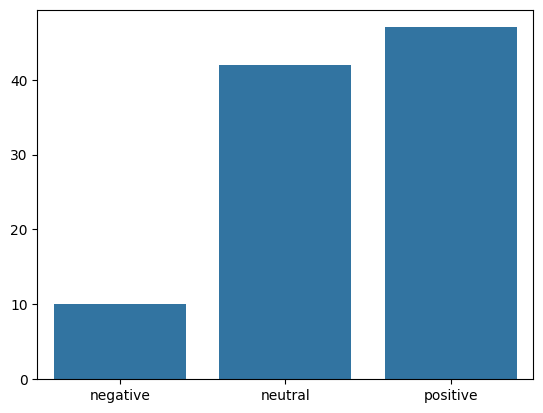

In [29]:
import seaborn as sns

# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

The customers are generally satisfied with the room sizes, although many are still neutral and negative.

We can be even more specific when searching for reviews with the help of Pinecone's metadata filtering. For instance, we can specify a period in our query to ensure that search results only contain customer reviews for that period. This is helpful if you want to understand the customer's opinion during a specific period.

Let's do this for the same query as before. We will filter reviews from 25th December to 31st December 2015. Previously we added the `review_date` field as a timestamp to the metadata during indexing. We can convert the start and end date of the period to timestamp using the `get_timestamp` function and use a `$gte` (greater than or equal to) and a `$lte` (less than or equal to) filter to get reviews from only the selected period.

In [30]:
'''# generate timestamps for start and end time of the period
start_time = get_timestamp(["2015-12-25"])[0]
end_time = get_timestamp(["2015-12-31"])[0]'''

'# generate timestamps for start and end time of the period\nstart_time = get_timestamp(["2015-12-25"])[0]\nend_time = get_timestamp(["2015-12-31"])[0]'

In [31]:
'''query = "are the customers satisified with the room sizes of hotels in London?"
# generate query embeddings
xq = retriever.encode(query).tolist()
# query pinecone with query embeddings and the period filter
result = index.query(
    vector=xq,
    top_k=500,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})
# get an overall count of customer sentiment
sentiment = count_sentiment(result)
# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))'''

'query = "are the customers satisified with the room sizes of hotels in London?"\n# generate query embeddings\nxq = retriever.encode(query).tolist()\n# query pinecone with query embeddings and the period filter\nresult = index.query(\n    vector=xq,\n    top_k=500,\n    include_metadata=True,\n    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})\n# get an overall count of customer sentiment\nsentiment = count_sentiment(result)\n# plot a barchart using seaborn\nsns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))'

We have a slightly different result now. Almost the same number of customers had either a neutral or negative view of the room size during the selected period.

In [32]:
depts =[
    "IT",
    "Operation/Manufacturing/Production",
    "Administration",
    "Finance & Accounting",
    "Marketing",
    "R&D",
    "Sales",
    "Logistics",
    "Customer Support",
    "Legal",
]

We will look into five main areas:
  1. Room Size
  2. Cleanliness
  3. Staff
  4. Food
  5. AC

We have a query for each of these areas below.

In [35]:
queries = {
    "Diversity": "is the company engaging in diversity",
    #"Innovation": "innovation in the company",
    #"Creativity": "How is creativity supported by the amosphere?",
    #"Sustainability": "work environment commit to sustainbility",
    #"Collaboration": "collaboration in work"
}

We need to iterate through all the hotels and run these queries for each hotel. This would give us customer reviews relevant to the selected hotel areas. After that, we count the sentiment labels and plot results for each hotel.

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

dept_sentiments = []

# iterate through the hotels
for dept in depts:
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the hotel filter
        xc = index.query(vector=xq, top_k=500, include_metadata=True, filter={"dept": dept})
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            data = {
                "area": area,
                "label": k,
                "value": v
            }
            # add the data to result list
            result.append(data)
    # convert the
    dept_sentiments.append({"dept": dept, "df": pd.DataFrame(result)})


Let's see what our final data look like.

In [37]:
dept_sentiments[0]["df"]

,area,label,value
0,Diversity,negative,1
1,Diversity,neutral,4
2,Diversity,positive,5


We may now plot the final data to make inference.

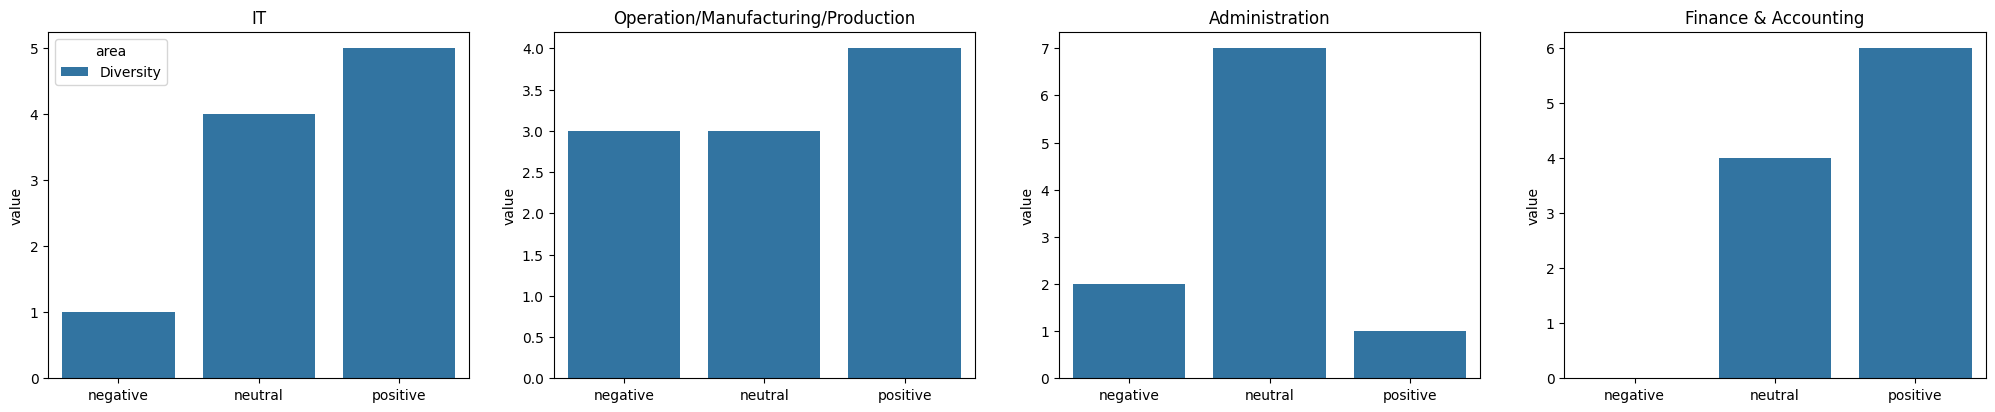

In [38]:
# create the figure and axes to plot barchart for all hotels
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 4.5))
plt.subplots_adjust(hspace=0.25)

counter = 0
# iterate through each hotel in the list and plot a barchart
for d, ax in zip(dept_sentiments, axs.ravel()):
    # plot barchart for each hotel
    sns.barplot(x="label", y="value", hue="area", data=d["df"], ax=ax)
    # display the hotel names
    ax.set_title(d["dept"])
    # remove x labels
    ax.set_xlabel("")
    # remove legend from all charts except for the first one
    counter += 1
    if counter != 1: ax.get_legend().remove()
# display the full figure
plt.show()

The following observations can be made for the hotels based on the sentiment analysis:
1.  **Strand Palace Hotel:** most customers were pleased with the staff, food, and cleanliness of the rooms, while a considerable number of them were not very satisfied with the room sizes and the AC.
2.  **Britannia International Hotel Canary Wharf:** customers were quite happy with the room size, but the majority were not satisfied with the AC.
3.  **Grand Royale London Hyde Park**: the majority of the customers were not satisfied with the room size, while a good number of them were pretty satisfied with the food, staff, AC, and cleanliness of the rooms.
4.  **Intercontinental London The O2**: the majority of the customers were really happy with the selected five areas, making this hotel the best among the selected hotels.


Although we have experimented with a few selected areas, you can get creative with your queries and get the sentiment around your area of interest immediately. This approach can even be applied to live data as the Pinecone index refreshes in real-time and performs vector searches across billions of documents with millisecond latency.

# Delete Index

Delete the index if you're finished to save resources:

In [ ]:
pinecone.delete_index(sentiment-mining)

---